# YOLO Dataset Creation for Original, Snow, and Generated Images

This notebook processes three datasets (original, original_snow, and generated) into YOLO format with proper class ID mapping. It includes **advanced filtering techniques** for generated images to account for CycleGAN's potential loss of details, and provides visualization tools for all three datasets.

## 0. Download and Setup Dataset

In [ ]:
import gdown
import zipfile
import os

# Create base directory
base_dir = "./zip_dataset"
os.makedirs(base_dir, exist_ok=True)

# Download the dataset from Google Drive
print("Downloading dataset from Google Drive...")
url = "https://drive.google.com/uc?id=14qs3q589VUVorn5rfmSUBgcYtbzf8fmE"  # Direct download link
output_path = os.path.join(base_dir, "dataset.zip")

# Download file
gdown.download(url, output_path, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=14qs3q589VUVorn5rfmSUBgcYtbzf8fmE
From (redirected): https://drive.google.com/uc?id=14qs3q589VUVorn5rfmSUBgcYtbzf8fmE&confirm=t&uuid=9cea446e-07cf-4cae-bd2c-82d5753f6c14
To: /mnt3/peter/finetune/Task2_dataset/dataset.zip
100%|██████████| 3.82G/3.82G [01:10<00:00, 54.1MB/s]


'./Task2_dataset/dataset.zip'

In [9]:

# Extract the zip file
print("Extracting dataset...")
with zipfile.ZipFile(output_path, "r") as zip_ref:
    zip_ref.extractall(".")

print("Dataset downloaded and extracted successfully!")

Extracting dataset...
Dataset downloaded and extracted successfully!


## 1. Import Required Libraries

In [8]:
import os
import json
import shutil
from pathlib import Path
import yaml
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import math
from ultralytics import YOLO  # For IoU-based verification (optional)

## 2. Define Directory Structure and Parameters

In [17]:
# Base directory
base_dir = "./task2_datasets"

# Source directories
original_images_dir = os.path.join(base_dir, "original_images")
generated_images_dir = os.path.join(base_dir, "generated_images")
original_snow_images_dir = os.path.join(base_dir, "original_snow_images")
labels_dir = os.path.join(base_dir, "original_lables")
original_snow_labels_dir = os.path.join(base_dir, "original_snow_labels")

# Output directories for YOLO format
yolo_original_dir = os.path.join(base_dir, "YOLO_original")
yolo_original_snow_dir = os.path.join(base_dir, "YOLO_original_snow")
yolo_generated_dir = os.path.join(base_dir, "YOLO_generated")

# Create output directories
os.makedirs(yolo_original_dir, exist_ok=True)
os.makedirs(yolo_original_snow_dir, exist_ok=True)
os.makedirs(yolo_generated_dir, exist_ok=True)

# Create YOLO subdirectories
for yolo_dir in [yolo_original_dir, yolo_generated_dir, yolo_original_snow_dir]:
    os.makedirs(os.path.join(yolo_dir, "images", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dir, "images", "val"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dir, "labels", "train"), exist_ok=True)
    os.makedirs(os.path.join(yolo_dir, "labels", "val"), exist_ok=True)

# Define bounding box filtering parameters for generated/modified images
MIN_BBOX_AREA = 100  # pixels squared - minimum area threshold
MIN_BBOX_DIAGONAL = 15  # pixels - minimum diagonal length
MIN_BBOX_DIMENSION = 10  # pixels - minimum width or height

# IoU verification parameters (optional advanced filtering)
USE_IOU_VERIFICATION = False  # Set to True to enable IoU-based verification
IOU_THRESHOLD = 0.3  # Minimum IoU between predicted and transferred boxes

## 3. Create Proper COCO to YOLO Class Mapping

In [18]:
def create_coco_to_yolo_mapping(coco_json_path):
    """
    Create a mapping from COCO class IDs to YOLO class IDs (0-indexed)
    """
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    
    # Get unique category IDs from annotations
    category_ids = set()
    for ann in coco_data['annotations']:
        category_ids.add(ann['category_id'])
    
    # Sort category IDs for consistent mapping
    sorted_ids = sorted(category_ids)
    
    # Create mapping: COCO ID -> YOLO ID (0-indexed)
    coco_to_yolo = {coco_id: yolo_id for yolo_id, coco_id in enumerate(sorted_ids)}
    
    # Create reverse mapping: YOLO ID -> class name
    yolo_names = {}
    class_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    for coco_id, yolo_id in coco_to_yolo.items():
        if coco_id in class_id_to_name:
            yolo_names[yolo_id] = class_id_to_name[coco_id]
    
    return coco_to_yolo, yolo_names

## 4. Helper Functions for File Discovery and Conversion

In [19]:
def find_actual_files(source_dir, split='train'):
    """
    Find all actual image files in the source directory
    Returns a dictionary mapping filename to full path
    """
    file_map = {}
    
    # Search for all image files in the directory and subdirectories
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        for root, dirs, files in os.walk(source_dir):
            for file in files:
                if file.endswith(ext.replace('*', '')):
                    full_path = os.path.join(root, file)
                    # Store with filename as key
                    file_map[file] = full_path
                    
                    # Also store with relative path if it includes subdirectories
                    rel_path = os.path.relpath(full_path, source_dir)
                    file_map[rel_path] = full_path
    
    return file_map

def match_annotation_to_file(filename, file_map):
    """
    Try to match annotation filename to actual file
    """
    # Try direct match first
    base_name = os.path.basename(filename)
    if base_name in file_map:
        return file_map[base_name]
    
    # Try with relative path
    if filename in file_map:
        return file_map[filename]
    
    # Try variations
    variations = [
        filename.replace('/', '_'),  # Replace slashes with underscores
        base_name.replace('_rgb_anon.png', '_rgb_ref_anon.png'),  # Original -> reference naming
        base_name.replace('_rgb_ref_anon.png', '_rgb_anon.png'),  # Reference -> original naming
    ]
    
    for var in variations:
        if var in file_map:
            return file_map[var]
    
    return None

def coco_to_yolo_bbox(bbox, img_width, img_height):
    """
    Convert COCO bounding box (x_min, y_min, width, height) to YOLO format
    (x_center, y_center, width, height) all normalized
    """
    x_min, y_min, width, height = bbox
    
    # Calculate center coordinates
    x_center = x_min + width / 2
    y_center = y_min + height / 2
    
    # Normalize coordinates
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height
    
    return x_center_norm, y_center_norm, width_norm, height_norm

def calculate_bbox_diagonal(bbox):
    """
    Calculate the diagonal length of a bounding box
    
    Args:
        bbox: Bounding box in COCO format (x_min, y_min, width, height)
    
    Returns:
        float: Diagonal length in pixels
    """
    x_min, y_min, width, height = bbox
    return math.sqrt(width**2 + height**2)

## 5. Advanced Filtering Functions

In [20]:
def should_keep_bbox(bbox, img_width, img_height, apply_filters=False):
    """
    Determine if a bounding box should be kept based on multiple criteria
    
    Args:
        bbox: Bounding box in COCO format (x_min, y_min, width, height)
        img_width: Image width in pixels
        img_height: Image height in pixels
        apply_filters: Whether to apply filtering criteria
    
    Returns:
        bool: True if the box should be kept, False otherwise
    """
    if not apply_filters:
        return True
    
    x_min, y_min, width, height = bbox
    
    # Filter 1: Minimum area
    area = width * height
    if area < MIN_BBOX_AREA:
        return False
    
    # Filter 2: Minimum diagonal length
    diagonal = calculate_bbox_diagonal(bbox)
    if diagonal < MIN_BBOX_DIAGONAL:
        return False
    
    # Filter 3: Minimum dimension (width or height)
    if width < MIN_BBOX_DIMENSION or height < MIN_BBOX_DIMENSION:
        return False
    
    # Filter 4: Box must be completely within the image
    if x_min < 0 or y_min < 0 or x_min + width > img_width or y_min + height > img_height:
        return False
    
    return True

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes
    
    Args:
        box1: First box in format (x_min, y_min, width, height)
        box2: Second box in format (x_min, y_min, width, height)
        
    Returns:
        float: IoU value between 0 and 1
    """
    # Convert to corner format
    box1_x1, box1_y1, box1_w, box1_h = box1
    box1_x2, box1_y2 = box1_x1 + box1_w, box1_y1 + box1_h
    
    box2_x1, box2_y1, box2_w, box2_h = box2
    box2_x2, box2_y2 = box2_x1 + box2_w, box2_y1 + box2_h
    
    # Get coordinates of intersection
    x_left = max(box1_x1, box2_x1)
    y_top = max(box1_y1, box2_y1)
    x_right = min(box1_x2, box2_x2)
    y_bottom = min(box1_y2, box2_y2)
    
    # Check if there is intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calculate area of intersection
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # Calculate area of both boxes
    box1_area = box1_w * box1_h
    box2_area = box2_w * box2_h
    
    # Calculate IoU
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou

def verify_bbox_with_yolo(image_path, bbox, class_id, iou_threshold=IOU_THRESHOLD):
    """
    Verify if a transferred bounding box is valid using a pre-trained YOLO model
    
    Args:
        image_path: Path to the image
        bbox: Bounding box in COCO format (x_min, y_min, width, height)
        class_id: Class ID of the object
        iou_threshold: Minimum IoU required to keep the box
        
    Returns:
        tuple: (is_valid, best_iou, best_pred_class)
    """
    if not USE_IOU_VERIFICATION:
        return True, 1.0, class_id
    
    try:
        # Load a pre-trained YOLO model
        model = YOLO("yolo.pt")  # Use the appropriate model path
        
        # Run prediction on the image
        results = model(image_path)
        
        # Extract predictions
        predictions = results[0].boxes
        
        if len(predictions) == 0:
            return False, 0.0, None
        
        # Convert bbox to format for IoU calculation
        x_min, y_min, width, height = bbox
        
        # Find best matching prediction based on IoU
        best_iou = 0.0
        best_pred_class = None
        
        for pred in predictions:
            pred_bbox = pred.xyxy[0].cpu().numpy()  # Get bounding box coordinates
            pred_x1, pred_y1, pred_x2, pred_y2 = pred_bbox
            
            # Convert prediction to COCO format for IoU calculation
            pred_coco = [
                pred_x1, 
                pred_y1, 
                pred_x2 - pred_x1,  # width
                pred_y2 - pred_y1   # height
            ]
            
            iou = calculate_iou(bbox, pred_coco)
            
            if iou > best_iou:
                best_iou = iou
                best_pred_class = int(pred.cls[0])
        
        # Check if the best IoU exceeds the threshold
        is_valid = best_iou >= iou_threshold
        
        return is_valid, best_iou, best_pred_class
        
    except Exception as e:
        print(f"Error during YOLO verification: {e}")
        return True, 0.0, class_id  # Default to keeping the box if verification fails

## 6. Load and Process Annotations with Enhanced Filtering

In [21]:
def load_coco_json(json_path):
    """
    Load and parse COCO JSON annotation file
    """
    with open(json_path, 'r') as f:
        return json.load(f)

def get_images_with_bbox_and_files(coco_data, source_dir, coco_to_yolo_mapping, split='train'):
    """
    Get images that have both bounding boxes AND exist in the file system
    Returns dictionary mapping image file names to their info and annotations
    """
    # Find all actual files
    file_map = find_actual_files(source_dir, split)
    
    # Create image ID to info mapping
    image_id_to_info = {img['id']: img for img in coco_data['images']}
    
    # Create category mapping (ID to name) using YOLO IDs
    class_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    yolo_category_mapping = {}
    
    for coco_id, yolo_id in coco_to_yolo_mapping.items():
        if coco_id in class_id_to_name:
            yolo_category_mapping[yolo_id] = class_id_to_name[coco_id]
    
    # Group annotations by image ID
    annotations_by_image = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_by_image:
            annotations_by_image[img_id] = []
        annotations_by_image[img_id].append(ann)
    
    # Filter for images with bounding boxes AND existing files
    images_with_bbox_and_files = {}
    
    for img_id, annotations in annotations_by_image.items():
        img_info = image_id_to_info[img_id]
        filename = img_info['file_name']
        
        # Check if file actually exists
        actual_file_path = match_annotation_to_file(filename, file_map)
        if actual_file_path is None:
            continue  # Skip if file doesn't exist
        
        img_width = img_info['width']
        img_height = img_info['height']
        
        # Convert COCO annotations to YOLO annotations
        yolo_annotations = []
        for ann in annotations:
            coco_class_id = ann['category_id']
            if coco_class_id in coco_to_yolo_mapping:
                yolo_class_id = coco_to_yolo_mapping[coco_class_id]
                # Create new annotation with YOLO class ID
                yolo_ann = ann.copy()
                yolo_ann['category_id'] = yolo_class_id
                yolo_annotations.append(yolo_ann)
        
        # Store annotations for this image
        images_with_bbox_and_files[filename] = {
            'width': img_width,
            'height': img_height,
            'annotations': yolo_annotations,
            'category_mapping': yolo_category_mapping,
            'actual_path': actual_file_path
        }
    
    return images_with_bbox_and_files

def create_yolo_labels_with_advanced_filtering(images_with_annotations, output_dir, apply_filters=False, is_generated=False):
    """
    Create YOLO label files from image annotations with advanced filtering options
    
    Args:
        images_with_annotations: Dictionary of images with their annotations
        output_dir: Output directory for label files
        apply_filters: Whether to apply size-based filters
        is_generated: Whether this is for generated/modified images (enables IoU verification)
    """
    os.makedirs(output_dir, exist_ok=True)
    processed_count = 0
    filtered_stats = {
        'total_boxes': 0,
        'kept_boxes': 0,
        'area_filtered': 0,
        'diagonal_filtered': 0,
        'dimension_filtered': 0,
        'iou_filtered': 0
    }
    
    for filename, img_data in images_with_annotations.items():
        img_width = img_data['width']
        img_height = img_data['height']
        annotations = img_data['annotations']
        actual_image_path = img_data['actual_path']
        
        # Extract just the image filename without path
        image_name = os.path.basename(filename)
        label_filename = os.path.splitext(image_name)[0] + '.txt'
        label_path = os.path.join(output_dir, label_filename)
        
        # Track boxes filtered by IoU verification for this image
        iou_filtered_boxes = 0
        
        with open(label_path, 'w') as f:
            for ann in annotations:
                filtered_stats['total_boxes'] += 1
                bbox = ann['bbox']
                class_id = ann['category_id']  # Already in YOLO format (0-indexed)
                
                # Apply basic filtering (size, diagonal, etc.)
                if apply_filters:
                    # Area check
                    area = bbox[2] * bbox[3]
                    if area < MIN_BBOX_AREA:
                        filtered_stats['area_filtered'] += 1
                        continue
                    
                    # Diagonal check
                    diagonal = calculate_bbox_diagonal(bbox)
                    if diagonal < MIN_BBOX_DIAGONAL:
                        filtered_stats['diagonal_filtered'] += 1
                        continue
                    
                    # Minimum dimension check
                    if bbox[2] < MIN_BBOX_DIMENSION or bbox[3] < MIN_BBOX_DIMENSION:
                        filtered_stats['dimension_filtered'] += 1
                        continue
                
                # IoU verification for generated/modified images (optional)
                if is_generated and USE_IOU_VERIFICATION:
                    is_valid, iou, pred_class = verify_bbox_with_yolo(
                        actual_image_path, bbox, class_id, IOU_THRESHOLD
                    )
                    
                    if not is_valid:
                        filtered_stats['iou_filtered'] += 1
                        iou_filtered_boxes += 1
                        continue
                
                # If we've passed all filters, keep the box
                filtered_stats['kept_boxes'] += 1
                
                # Convert to YOLO format
                x_center_norm, y_center_norm, width_norm, height_norm = coco_to_yolo_bbox(
                    bbox, img_width, img_height
                )
                
                # Write to file: class_id x_center y_center width height
                f.write(f"{class_id} {x_center_norm} {y_center_norm} {width_norm} {height_norm}\n")
        
        # If using IoU verification, add a .flagged file for images with filtered boxes
        if is_generated and USE_IOU_VERIFICATION and iou_filtered_boxes > 0:
            flag_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}.flagged")
            with open(flag_path, 'w') as flag_file:
                flag_file.write(f"Filtered {iou_filtered_boxes} boxes due to low IoU\n")
        
        processed_count += 1
    
    # Print filtering statistics
    if apply_filters:
        print(f"\nFiltering statistics:")
        print(f"  Total boxes: {filtered_stats['total_boxes']}")
        print(f"  Kept boxes: {filtered_stats['kept_boxes']} ({filtered_stats['kept_boxes']/max(1, filtered_stats['total_boxes'])*100:.1f}%)")
        print(f"  Filtered by area: {filtered_stats['area_filtered']}")
        print(f"  Filtered by diagonal: {filtered_stats['diagonal_filtered']}")
        print(f"  Filtered by dimension: {filtered_stats['dimension_filtered']}")
        if USE_IOU_VERIFICATION:
            print(f"  Filtered by IoU: {filtered_stats['iou_filtered']}")
    
    return processed_count, filtered_stats

def copy_images_with_bbox(target_dir, images_with_annotations):
    """
    Copy only images that have bounding boxes and exist in the file system
    
    Args:
        target_dir: Target directory for flat file structure
        images_with_annotations: Dictionary of images with their annotations
    """
    os.makedirs(target_dir, exist_ok=True)
    copied_count = 0
    
    for filename, img_data in images_with_annotations.items():
        source_path = img_data['actual_path']
        
        # Extract just the image filename for target
        image_name = os.path.basename(source_path)
        target_path = os.path.join(target_dir, image_name)
        
        # Copy image
        shutil.copy2(source_path, target_path)
        print(f"Copied: {image_name}")
        copied_count += 1
    
    return copied_count

## 7. Create YOLO Configuration Files with Proper Class Names

In [22]:
def create_yolo_config(output_dir, name, class_names):
    """
    Create YOLO data.yaml configuration file
    """
    config = {
        'path': output_dir,
        'train': 'images/train',
        'val': 'images/val',
        'nc': len(class_names),
        'names': class_names
    }
    
    yaml_path = os.path.join(output_dir, 'data.yaml')
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)
    
    print(f"Created config at: {yaml_path}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Class names: {class_names}")
    
    return yaml_path

## 8. Main Processing Pipeline

In [23]:
# Load annotations for the three datasets
print("Loading annotations...")
train_coco = load_coco_json(os.path.join(labels_dir, "instancesonly_train_gt_ref_detection.json"))
val_coco = load_coco_json(os.path.join(labels_dir, "instancesonly_val_gt_ref_detection.json"))

# Load annotations for original_snow dataset 
train_snow_coco = load_coco_json(os.path.join(original_snow_labels_dir, "instancesonly_train_gt_ref_detection.json"))
val_snow_coco = load_coco_json(os.path.join(original_snow_labels_dir, "instancesonly_val_gt_ref_detection.json"))

# Create COCO to YOLO class mapping
coco_to_yolo_mapping, yolo_class_names = create_coco_to_yolo_mapping(
    os.path.join(labels_dir, "instancesonly_train_gt_ref_detection.json")
)

# Create ordered list of class names
ordered_class_names = []
for i in range(len(yolo_class_names)):
    if i in yolo_class_names:
        ordered_class_names.append(yolo_class_names[i])

print(f"COCO to YOLO class mapping: {coco_to_yolo_mapping}")
print(f"YOLO class names: {ordered_class_names}")

# PART 1: Process original images
print("\n=== Processing original images ===")

# Get images with bounding boxes that actually exist in the file system
train_images_with_bbox = get_images_with_bbox_and_files(
    train_coco, original_images_dir, coco_to_yolo_mapping, 'train'
)
val_images_with_bbox = get_images_with_bbox_and_files(
    val_coco, original_images_dir, coco_to_yolo_mapping, 'val'
)

print(f"Found {len(train_images_with_bbox)} train images with bounding boxes and existing files")
print(f"Found {len(val_images_with_bbox)} validation images with bounding boxes and existing files")

# Copy train images
train_count = copy_images_with_bbox(
    os.path.join(yolo_original_dir, "images", "train"),
    train_images_with_bbox
)
print(f"Copied {train_count} training images")

# Copy val images
val_count = copy_images_with_bbox(
    os.path.join(yolo_original_dir, "images", "val"),
    val_images_with_bbox
)
print(f"Copied {val_count} validation images")

# Create YOLO labels for train (no filtering for original images)
train_label_count, _ = create_yolo_labels_with_advanced_filtering(
    train_images_with_bbox,
    os.path.join(yolo_original_dir, "labels", "train"),
    apply_filters=False
)
print(f"Created {train_label_count} training label files")

# Create YOLO labels for val (no filtering for original images)
val_label_count, _ = create_yolo_labels_with_advanced_filtering(
    val_images_with_bbox,
    os.path.join(yolo_original_dir, "labels", "val"),
    apply_filters=False
)
print(f"Created {val_label_count} validation label files")

# PART 2: Process original_snow images
print("\n=== Processing original_snow images ===")

# Get images with bounding boxes that actually exist in the snow images directory
snow_train_images_with_bbox = get_images_with_bbox_and_files(
    train_snow_coco, original_snow_images_dir, coco_to_yolo_mapping, 'train'
)
snow_val_images_with_bbox = get_images_with_bbox_and_files(
    val_snow_coco, original_snow_images_dir, coco_to_yolo_mapping, 'val'
)

print(f"Found {len(snow_train_images_with_bbox)} snow train images with bounding boxes and existing files")
print(f"Found {len(snow_val_images_with_bbox)} snow validation images with bounding boxes and existing files")

# Copy train images (snow)
snow_train_count = copy_images_with_bbox(
    os.path.join(yolo_original_snow_dir, "images", "train"),
    snow_train_images_with_bbox
)
print(f"Copied {snow_train_count} snow training images")

# Copy val images (snow)
snow_val_count = copy_images_with_bbox(
    os.path.join(yolo_original_snow_dir, "images", "val"),
    snow_val_images_with_bbox
)
print(f"Copied {snow_val_count} snow validation images")

# Create YOLO labels for snow train (apply moderate filtering for snow images)
snow_train_label_count, snow_train_stats = create_yolo_labels_with_advanced_filtering(
    snow_train_images_with_bbox,
    os.path.join(yolo_original_snow_dir, "labels", "train"),
    apply_filters=True,
    is_generated=True  # Enable IoU verification if USE_IOU_VERIFICATION is True
)
print(f"Created {snow_train_label_count} snow training label files with filtering")

# Create YOLO labels for snow val (apply moderate filtering for snow images)
snow_val_label_count, snow_val_stats = create_yolo_labels_with_advanced_filtering(
    snow_val_images_with_bbox,
    os.path.join(yolo_original_snow_dir, "labels", "val"),
    apply_filters=True,
    is_generated=True  # Enable IoU verification if USE_IOU_VERIFICATION is True
)
print(f"Created {snow_val_label_count} snow validation label files with filtering")

# PART 3: Process generated images
print("\n=== Processing generated images ===")

# Get images with bounding boxes that actually exist in the generated directory
gen_train_images_with_bbox = get_images_with_bbox_and_files(
    train_coco, generated_images_dir, coco_to_yolo_mapping, 'train'
)
gen_val_images_with_bbox = get_images_with_bbox_and_files(
    val_coco, generated_images_dir, coco_to_yolo_mapping, 'val'
)

print(f"Found {len(gen_train_images_with_bbox)} generated train images with bounding boxes and existing files")
print(f"Found {len(gen_val_images_with_bbox)} generated validation images with bounding boxes and existing files")

# Copy train images (generated)
gen_train_count = copy_images_with_bbox(
    os.path.join(yolo_generated_dir, "images", "train"),
    gen_train_images_with_bbox
)
print(f"Copied {gen_train_count} generated training images")

# Copy val images (generated)
gen_val_count = copy_images_with_bbox(
    os.path.join(yolo_generated_dir, "images", "val"),
    gen_val_images_with_bbox
)
print(f"Copied {gen_val_count} generated validation images")

# Create YOLO labels for generated train images (with strict filtering)
gen_train_label_count, gen_train_stats = create_yolo_labels_with_advanced_filtering(
    gen_train_images_with_bbox,
    os.path.join(yolo_generated_dir, "labels", "train"),
    apply_filters=True,
    is_generated=True  # Enable IoU verification if USE_IOU_VERIFICATION is True
)
print(f"Created {gen_train_label_count} generated training label files with filtering")

# Create YOLO labels for generated val images (with strict filtering)
gen_val_label_count, gen_val_stats = create_yolo_labels_with_advanced_filtering(
    gen_val_images_with_bbox,
    os.path.join(yolo_generated_dir, "labels", "val"),
    apply_filters=True,
    is_generated=True  # Enable IoU verification if USE_IOU_VERIFICATION is True
)
print(f"Created {gen_val_label_count} generated validation label files with filtering")

# Create config files for all three datasets
print("\n=== Creating configuration files ===")

# Create config for original dataset
original_config = create_yolo_config(
    yolo_original_dir,
    'original_dataset',
    ordered_class_names
)

# Create config for original_snow dataset
original_snow_config = create_yolo_config(
    yolo_original_snow_dir,
    'original_snow_dataset',
    ordered_class_names
)

# Create config for generated dataset  
generated_config = create_yolo_config(
    yolo_generated_dir,
    'generated_dataset',
    ordered_class_names
)

Loading annotations...
COCO to YOLO class mapping: {24: 0, 25: 1, 26: 2, 27: 3, 28: 4, 31: 5, 32: 6, 33: 7}
YOLO class names: ['person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']

=== Processing original images ===
Found 200 train images with bounding boxes and existing files
Found 50 validation images with bounding boxes and existing files
Copied: GP010607_frame_000839_rgb_ref_anon.png
Copied: GP010607_frame_000734_rgb_ref_anon.png
Copied: GP010607_frame_000517_rgb_ref_anon.png
Copied: GP010607_frame_000819_rgb_ref_anon.png
Copied: GP010607_frame_000576_rgb_ref_anon.png
Copied: GP010607_frame_000768_rgb_ref_anon.png
Copied: GP010607_frame_000849_rgb_ref_anon.png
Copied: GP010607_frame_000355_rgb_ref_anon.png
Copied: GP010607_frame_000799_rgb_ref_anon.png
Copied: GP010607_frame_000760_rgb_ref_anon.png
Copied: GP010607_frame_000382_rgb_ref_anon.png
Copied: GP010607_frame_000324_rgb_ref_anon.png
Copied: GP010607_frame_000639_rgb_ref_anon.png
Copied: GP010607_frame

## 9. Visualization Functions

In [24]:
import os
import yaml
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import numpy as np

def load_yolo_label(label_path, img_width, img_height):
    """
    Load YOLO format label file and convert to pixel coordinates
    Returns list of (class_id, x_min, y_min, x_max, y_max)
    """
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    x_center_norm = float(parts[1])
                    y_center_norm = float(parts[2])
                    width_norm = float(parts[3])
                    height_norm = float(parts[4])
                    
                    # Convert to pixel coordinates
                    x_center = x_center_norm * img_width
                    y_center = y_center_norm * img_height
                    width = width_norm * img_width
                    height = height_norm * img_height
                    
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                    
                    boxes.append((class_id, x_min, y_min, x_max, y_max))
    return boxes

def convert_filename(filename, target_dataset):
    """
    Convert between the different naming conventions of the datasets
    
    Args:
        filename: Original filename
        target_dataset: 'original', 'snow', or 'generated'
        
    Returns:
        Converted filename for the target dataset
    """
    base_name = os.path.basename(filename)
    
    # Convert to base name without the specific suffix
    if '_rgb_ref_anon' in base_name:
        # It's an original/generated format file
        base_part = base_name.replace('_rgb_ref_anon', '')
    elif '_rgb_anon' in base_name:
        # It's a snow format file
        base_part = base_name.replace('_rgb_anon', '')
    else:
        # No recognized pattern, return as is
        return base_name
    
    # Add the correct suffix based on target dataset
    if target_dataset == 'snow':
        return f"{base_part}_rgb_anon.png"
    else:  # original or generated
        return f"{base_part}_rgb_ref_anon.png"

def find_common_images(base_dir, num_images=5, split='train'):
    """
    Find matching images across all three datasets, accounting for filename differences
    """
    # Get directories
    original_dir = os.path.join(base_dir, "YOLO_original", "images", split)
    snow_dir = os.path.join(base_dir, "YOLO_original_snow", "images", split)
    generated_dir = os.path.join(base_dir, "YOLO_generated", "images", split)
    
    if not all(os.path.exists(d) for d in [original_dir, snow_dir, generated_dir]):
        print("One or more dataset directories not found")
        return []
    
    # Get lists of image files (base names only)
    original_images = [f for f in os.listdir(original_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    snow_images = [f for f in os.listdir(snow_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    generated_images = [f for f in os.listdir(generated_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Create a mapping from standardized names to actual filenames
    mapping = {}
    
    # Add original images to mapping
    for img in original_images:
        # Extract the non-suffix part (e.g., GOPR0607_frame_000207)
        if '_rgb_ref_anon' in img:
            key = img.replace('_rgb_ref_anon', '')
            if key not in mapping:
                mapping[key] = {'original': None, 'snow': None, 'generated': None}
            mapping[key]['original'] = img
    
    # Add snow images to mapping
    for img in snow_images:
        if '_rgb_anon' in img:
            key = img.replace('_rgb_anon', '')
            if key not in mapping:
                mapping[key] = {'original': None, 'snow': None, 'generated': None}
            mapping[key]['snow'] = img
    
    # Add generated images to mapping
    for img in generated_images:
        if '_rgb_ref_anon' in img:
            key = img.replace('_rgb_ref_anon', '')
            if key not in mapping:
                mapping[key] = {'original': None, 'snow': None, 'generated': None}
            mapping[key]['generated'] = img
    
    # Find keys that have images in all three datasets
    complete_sets = [k for k, v in mapping.items() 
                   if v['original'] is not None and 
                      v['snow'] is not None and 
                      v['generated'] is not None]
    
    if complete_sets:
        selected_keys = random.sample(complete_sets, min(num_images, len(complete_sets)))
        result = []
        
        for key in selected_keys:
            # Use the original image filename as the reference, with mapping info
            result.append({
                'key': key,
                'original': mapping[key]['original'],
                'snow': mapping[key]['snow'],
                'generated': mapping[key]['generated']
            })
        
        return result
    else:
        print("No complete image sets found across all three datasets")
        # Try to find images in at least two datasets
        partial_sets = [k for k, v in mapping.items() 
                     if sum(1 for val in v.values() if val is not None) >= 2]
        
        if partial_sets:
            print(f"Found {len(partial_sets)} images in at least two datasets")
            selected_keys = random.sample(partial_sets, min(num_images, len(partial_sets)))
            result = []
            
            for key in selected_keys:
                result.append({
                    'key': key,
                    'original': mapping[key]['original'],
                    'snow': mapping[key]['snow'],
                    'generated': mapping[key]['generated']
                })
            
            return result
        else:
            print("No matching images found")
            return []

def visualize_all_datasets(base_dir, image_set, split='train', with_bbox=True):
    """
    Visualize an image triplet from all three datasets side by side
    
    Args:
        base_dir: Base directory containing all datasets
        image_set: Dictionary with filenames for all three datasets
        split: 'train' or 'val'
        with_bbox: Whether to draw bounding boxes
    """
    # Get directories
    original_dir = os.path.join(base_dir, "YOLO_original")
    snow_dir = os.path.join(base_dir, "YOLO_original_snow")
    generated_dir = os.path.join(base_dir, "YOLO_generated")
    
    # Load class names from YAML
    original_yaml = os.path.join(original_dir, 'data.yaml')
    if os.path.exists(original_yaml):
        with open(original_yaml, 'r') as f:
            config = yaml.safe_load(f)
            class_names = config.get('names', [])
    else:
        print(f"Warning: {original_yaml} not found")
        class_names = [f"Class {i}" for i in range(10)]  # Fallback
    
    # Define the datasets to process
    datasets = [
        {
            'name': 'Original',
            'dir': original_dir,
            'filename': image_set.get('original'),
        },
        {
            'name': 'Snow',
            'dir': snow_dir,
            'filename': image_set.get('snow'),
        },
        {
            'name': 'Generated',
            'dir': generated_dir,
            'filename': image_set.get('generated'),
        }
    ]
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define colors for bounding boxes
    colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'orange', 'purple']
    
    # Initialize with blank white images
    for ax in axes:
        ax.imshow(np.ones((100, 100, 3), dtype=np.uint8) * 255)
        ax.axis('off')
    
    # Process each dataset
    for i, dataset in enumerate(datasets):
        # Skip if no filename available for this dataset
        if dataset['filename'] is None:
            axes[i].set_title(f"{dataset['name']} (Missing)", fontsize=14, color='red')
            continue
        
        # Construct paths
        img_path = os.path.join(dataset['dir'], "images", split, dataset['filename'])
        label_path = os.path.join(dataset['dir'], "labels", split, 
                                 os.path.splitext(dataset['filename'])[0] + '.txt')
        
        # Check if image exists
        if not os.path.exists(img_path):
            axes[i].set_title(f"{dataset['name']} (File not found)", fontsize=14, color='red')
            continue
        
        # Load and display image
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(f"{dataset['name']}", fontsize=14)
            axes[i].axis('off')
            
            # Draw bounding boxes if requested
            if with_bbox and os.path.exists(label_path):
                width, height = img.size
                boxes = load_yolo_label(label_path, width, height)
                
                # Draw bounding boxes
                for class_id, x_min, y_min, x_max, y_max in boxes:
                    # Get color for this class
                    color = colors[class_id % len(colors)]
                    
                    # Draw rectangle
                    rect = patches.Rectangle(
                        (x_min, y_min), x_max - x_min, y_max - y_min,
                        linewidth=2, edgecolor=color, facecolor='none'
                    )
                    axes[i].add_patch(rect)
                    
                    # Get class name
                    if class_id < len(class_names):
                        class_name = class_names[class_id]
                    else:
                        class_name = f"Class {class_id}"
                    
                    # Add text
                    axes[i].text(
                        x_min, y_min - 5, class_name, color=color, fontsize=10,
                        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1)
                    )
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            axes[i].set_title(f"{dataset['name']} (Error)", fontsize=14, color='red')
    
    plt.tight_layout()
    plt.suptitle(f"Image: {image_set['key']} ({'with' if with_bbox else 'without'} bounding boxes)", fontsize=16)
    plt.subplots_adjust(top=0.9)
    return fig

def visualize_multiple_triplets(base_dir, num_pairs=3, split='train'):
    """
    Visualize multiple triplets (original, snow, generated) with and without bounding boxes
    """
    image_sets = find_common_images(base_dir, num_images=num_pairs, split=split)
    
    if image_sets:
        print(f"\nVisualizing {len(image_sets)} image triplets...")
        
        for i, image_set in enumerate(image_sets):
            print(f"Triplet {i+1}: {image_set['key']}")
            
            # With bounding boxes
            fig_with_bbox = visualize_all_datasets(base_dir, image_set, split=split, with_bbox=True)
            if fig_with_bbox:
                plt.figure(fig_with_bbox.number)
                # plt.savefig(os.path.join(base_dir, f"{image_set['key']}_with_bbox.png"), dpi=300, bbox_inches='tight')
                plt.show()
                
            # Without bounding boxes
            fig_without_bbox = visualize_all_datasets(base_dir, image_set, split=split, with_bbox=False)
            if fig_without_bbox:
                plt.figure(fig_without_bbox.number)
                # plt.savefig(os.path.join(base_dir, f"{image_set['key']}_without_bbox.png"), dpi=300, bbox_inches='tight')
                plt.show()
    else:
        print("No image sets found to visualize")



## 10. Visualization Execution


=== Visualizing sample images ===

Visualizing 1 image triplets...
Triplet 1: GOPR0607_frame_001007.png


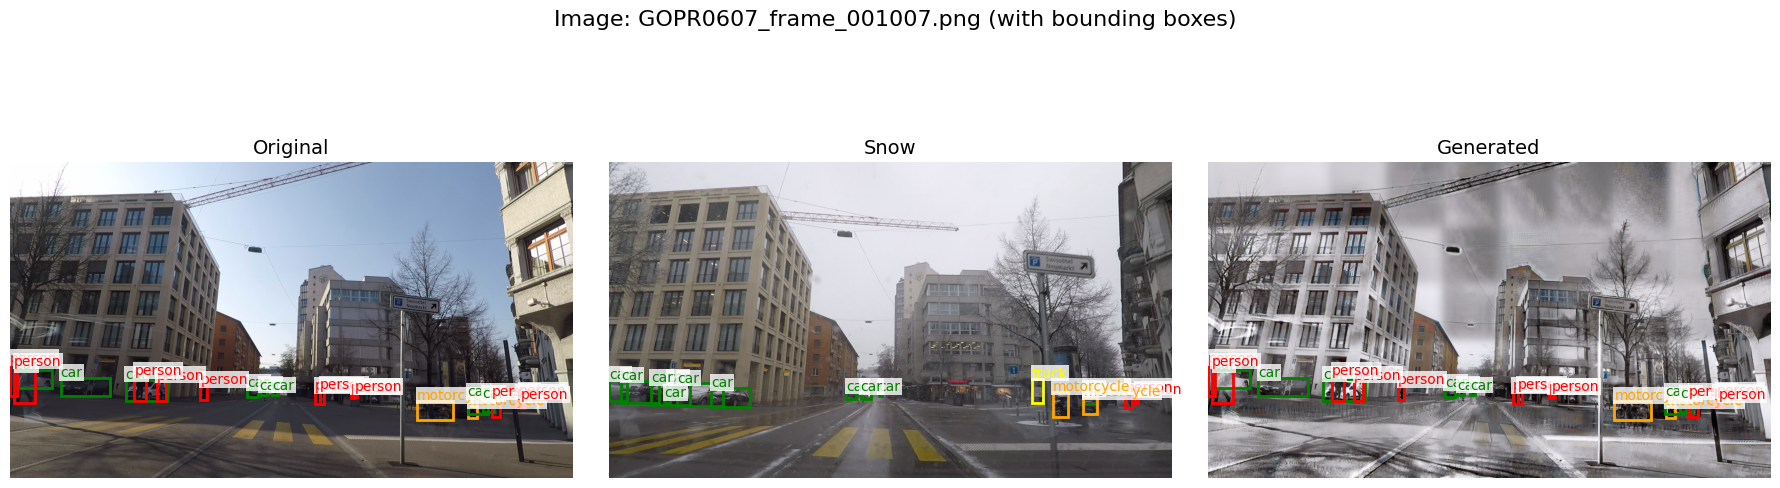

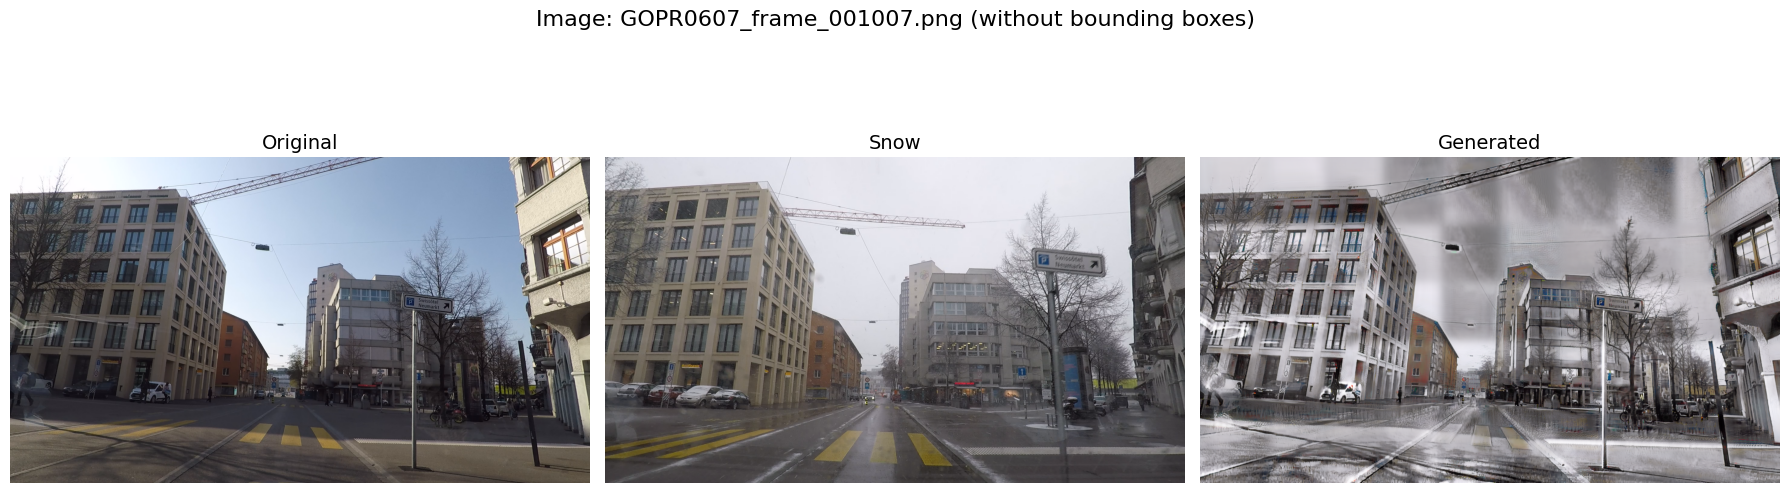

In [ ]:
# Visualize sample images from all three datasets
print("\n=== Visualizing sample images ===")
visualize_multiple_triplets(base_dir, num_pairs=1, split='train')